In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('weather_data.csv')

In [3]:
df = pd.DataFrame(df)

In [4]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2024-11-01 00:00,26.2,4.7,180,29.82,0.0,76,80,0.0,1063
1,2024-11-01 01:00,26.0,5.4,192,29.81,0.0,75,76,0.0,1063
2,2024-11-01 02:00,26.0,5.0,207,29.79,0.0,75,17,0.0,1000
3,2024-11-01 03:00,25.8,6.1,212,29.79,0.0,75,16,0.0,1000
4,2024-11-01 04:00,25.7,5.8,207,29.81,0.0,75,14,0.0,1000


In [5]:
df.duplicated().sum()

0

In [6]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [7]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.2,4.7,180,29.82,76,80
1,26.0,5.4,192,29.81,75,76
2,26.0,5.0,207,29.79,75,17
3,25.8,6.1,212,29.79,75,16
4,25.7,5.8,207,29.81,75,14


In [8]:
len(training)

744

In [9]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(training)

In [10]:
pd.DataFrame(training).head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.2,4.7,180,29.82,76,80
1,26.0,5.4,192,29.81,75,76
2,26.0,5.0,207,29.79,75,17
3,25.8,6.1,212,29.79,75,16
4,25.7,5.8,207,29.81,75,14


In [11]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [13]:
sequence_length = 6
forecast_horizon = 1

X, y = create_sequences(np.array(training), sequence_length, forecast_horizon)

In [14]:
split_ratio = 0.8
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [39]:
num_features = X.shape[2]

model = tf.keras.Sequential([    
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(384, return_sequences=False)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(num_features * forecast_horizon),  
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mae', metrics=['mean_absolute_error'])

In [40]:
# num_features = X.shape[2]

# x_input = tf.keras.layers.Input(shape=(sequence_length, num_features))
# x = scaler(x_input)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(384, return_sequences=True))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
# x = tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
# x = tf.keras.layers.Dense(num_features * forecast_horizon)(x)
# x_output = tf.keras.layers.Reshape((forecast_horizon, num_features))(x)

# model = tf.keras.models.Model(inputs=x_input, outputs=x_output)

# model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mae', metrics=['mean_absolute_error'])

In [41]:
init_weights = model.get_weights()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 6, 6)           │            12 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6, 1024)        │     1,597,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 1024)        │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 768)            │     3,248,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,158 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 6)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,100,626 (19.46 MB)

 Trainable params: 5,097,042 (19.44 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor = 0.5, patience=4, min_lr=1e-6)

In [43]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['mean_absolute_error'] <= 0.058 and logs['val_mean_absolute_error'] <= 0.060:
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

In [44]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [45]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[custom_early_stopping])
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr])

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 44.9937 - mean_absolute_error: 39.0191 - val_loss: 36.9157 - val_mean_absolute_error: 31.2861
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 23.0880 - mean_absolute_error: 17.6140 - val_loss: 32.8562 - val_mean_absolute_error: 27.9035
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 18.8306 - mean_absolute_error: 14.0352 - val_loss: 31.5034 - val_mean_absolute_error: 27.1500
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 16.8120 - mean_absolute_error: 12.5981 - val_loss: 22.7152 - val_mean_absolute_error: 18.8893
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 18.0890 - mean_absolute_error: 14.3809 - val_loss: 26.2541 - val_mean_absolute_error: 22.9193
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 20.1067 - mean_absolute_error: 16.8520 - val_loss: 19.7492 - val_mean_absolute_error: 16.7648
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 15.9023 

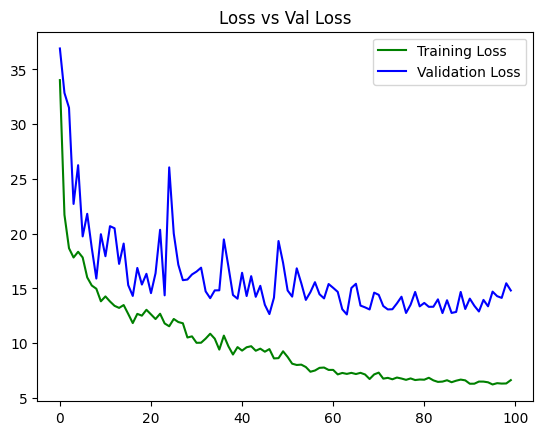

In [46]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

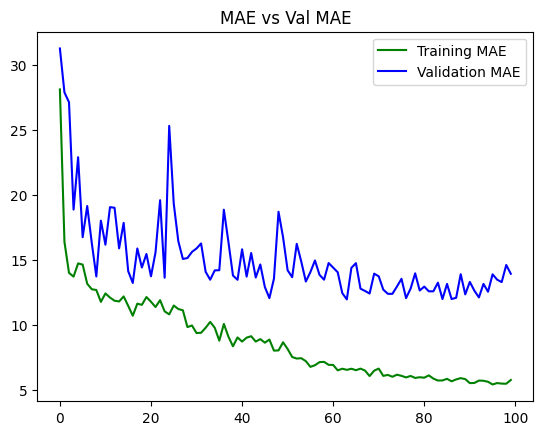

In [47]:
plt.plot(history.history['mean_absolute_error'], color='g', label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], color='b', label='Validation MAE')
plt.title("MAE vs Val MAE")
plt.legend()
plt.show()

In [48]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}".format(loss, mae))

Loss : 14.808621406555176, MAE : 13.950016975402832


In [49]:
predictions = model.predict(x_test)

print(predictions[2])
print(y_test[2])

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
[[ 26.067509   4.036495 146.38274   29.408798  74.92508   73.11756 ]]
[[ 26.6    3.6  155.    29.79  79.    41.  ]]


In [50]:
# tf.keras.models.save_model(model, 'forecasting.keras')
# model.save("forecasting.h5")